# Прогноз трафика на базовых станциях

In [1]:
gpu = False

# подключаем библиотеку функций для оптимизации работы с моделями
# https://github.com/alukyantsev/magic_ds/
from magic_ds_20211214 import *
from magic_ds_20211214.ml import *
if not gpu:
    from magic_ds_20211214.ml.sklearnex import *

# подключаем модели
from magic_ds.ml.model_linear import *
from magic_ds.ml.model_boost import *

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from psutil import virtual_memory
print(virtual_memory().total / 1e9)

16.395169792


In [3]:
if gpu:
    !nvidia-smi

### Считываем данные

In [5]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test  = pd.read_csv('test_public.csv', index_col=0)

In [6]:
# исключаем все колонки, которые есть в тестовой выборке, но нет в тренировочной
# также исключаем столбцы, в которых в тренировjчной выборке всегда одно значение
col_exclude_list = ['col_n10', 'col_n24', 'col_n36', 'col_n42', 'col_n56']
col_list = list(set(df_train.columns) & set(df_test.columns) - set(col_exclude_list))
col_list.sort()

In [7]:
# формируем единый датасет
df = pd.concat( [ df_train[col_list + ['mb']], df_test[col_list] ] ).reset_index(drop=True)

In [8]:
# сохраняем в словарь
d, d['test'] = {}, {}
d['test']['df'] = df_test[['id2', 'place_id', 'time_idx']]
split_dict_struct(d)

==================== Structure =====================

test -> df


### Изучаем и обрабатываем датасет

In [9]:
df_analyze = df[ df['mb'].map(lambda x: ~np.isnan(x)) ]
df_analyze

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,8,0.02
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,9,0.79
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,10,0.75
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,11,0.85
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,12,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860745,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.12,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.04,0.00,0.18,0.00,2,14604,39,0.53
860746,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,2,14604,40,0.53
860747,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,40,0.51
860748,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,2,14604,41,0.62


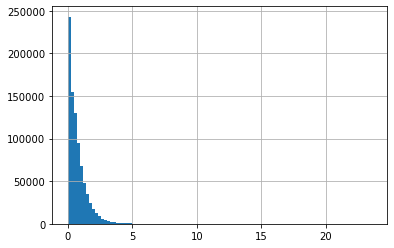

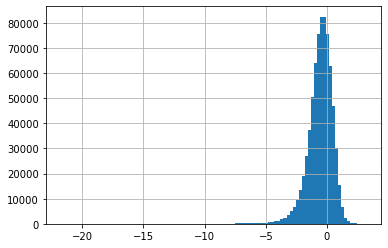

In [10]:
# смотрим распределение целевой переменной
df_analyze['mb'].hist(bins=100)
plt.show()
df_analyze['mb'].map(lambda x: np.log(x) if x>0 else np.nan).hist(bins=100)
plt.show()

In [11]:
analyze_unique(df_analyze, ['time_idx', 'place_id', 'id2'])

==================== time_idx (42 unique) ====================
41    21674
40    21608
39    21585
36    21576
38    21573
35    21571
37    21570
32    21564
31    21563
34    21562
29    21562
30    21560
33    21559
28    21374
27    21322
26    21269
25    21180
24    21133
23    21077
22    21016
21    20962
20    20925
19    20887
18    20870
17    20868
16    20398
15    20150
14    19856
13    19716
12    19600
11    19530
10    19399
9     19293
8     19190
7     19090
6     19061
5     19059
4     18758
3     18676
2     18601
1     18514
0     18449
Name: time_idx, dtype: int64 

==================== place_id (12458 unique) ====================
6037     210
13297    210
10624    210
608      210
5526     210
        ... 
3660       1
11315      1
8146       1
11055      1
10038      1
Name: place_id, Length: 12458, dtype: int64 

==================== id2 (5 unique) ====================
5    460389
0    220658
2    110773
4     45154
6     23776
Name: id2, dtype: int64 



In [12]:
df_analyze[ (df_analyze['place_id'] == 13297) & (df_analyze['id2'] == 2) ]

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
785408,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.58,0.00,0.00,0.06,2,13297,0,0.00
785413,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.79,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.64,0.00,0.00,0.06,2,13297,1,0.00
785420,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.69,0.00,0.00,0.06,2,13297,2,0.00
785426,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.75,0.00,0.00,0.06,2,13297,3,0.00
785430,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.94,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.03,0.00,0.00,0.06,0.77,0.00,0.00,0.09,2,13297,4,0.00
785435,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.06,0.81,0.00,0.00,0.09,2,13297,5,0.00
785440,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.06,0.81,0.00,0.00,0.09,2,13297,6,0.00
785444,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.06,0.83,0.00,0.00,0.09,2,13297,7,0.00
785451,0.00,0.00,0.00,0.00,0.00,0.51,0.00,1.03,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.06,0.00,0.00,0.06,0.91,0.17,0.00,0.09,2,13297,8,0.00
785456,0.00,0.00,0.00,0.00,0.00,8.41,0.00,1.03,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.70,0.00,0.06,0.25,0.00,0.00,0.00,0.04,1.00,0.00,0.00,0.06,0.89,0.12,0.00,0.09,2,13297,9,0.01


In [13]:
df_analyze[ (df_analyze['place_id'] == 13297) & (df_analyze['time_idx'] == 40) ]

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
785608,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,1.75,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,0,13297,40,0.71
785609,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.00,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,4,13297,40,0.00
785610,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.35,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,6,13297,40,0.21
785611,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.00,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,5,13297,40,0.00
785612,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.70,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,2,13297,40,0.73


In [14]:
df_analyze[ (df_analyze['id2'] == 6) & (df_analyze['time_idx'] == 2) ].head(50)

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
2163,0.00,0.00,0.15,0.00,0.00,0.00,0.00,2.30,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.97,0.00,0.00,0.48,0.00,0.00,0.97,0.00,0.06,3.71,0.00,0.00,0.09,1.62,0.00,3.72,0.68,6,34,2,0.00
7287,0.00,0.00,0.09,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.24,0.00,6,124,2,0.00
8540,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,143,2,0.00
10743,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.04,0.00,0.09,0.00,6,183,2,0.06
11373,0.00,0.00,0.00,0.00,0.00,4.33,0.00,0.59,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.56,0.00,0.00,0.00,6,195,2,0.00
14968,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.06,0.06,0.35,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,252,2,0.22
16890,0.00,0.00,0.00,0.00,0.00,16.82,0.00,1.21,0.00,4.33,0.00,0.00,0.00,0.00,0.51,1.18,0.35,0.00,0.58,9.94,0.00,0.00,0.00,0.25,1.99,0.00,0.00,0.35,0.85,0.00,0.00,0.82,6,290,2,0.37
18193,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.03,0.00,6,316,2,0.27
19878,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,6,346,2,0.00
25086,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,1.15,0.00,0.00,0.00,0.19,0.00,1.15,0.00,6,431,2,0.00


In [15]:
# добавляем поле среднее по id
mean_id = df_analyze.groupby(by=['id2']).mean()['mb']
df['mean_id_mb'] = df.drop('mb', axis=1).join(mean_id, on=['id2'], how='left')['mb']

# добавляем поле среднее по place
mean_place = df_analyze.groupby(by=['place_id']).mean()['mb']
df['mean_place_mb'] = df.drop('mb', axis=1).join(mean_place, on=['place_id'], how='left')['mb']

replace_arr = df[ df['mean_place_mb'].map(lambda x: np.isnan(x)) ]['mean_place_mb']
for i in replace_arr.index:
    df.loc[ df.index == i, 'mean_place_mb' ] = df.iloc[i]['mean_id_mb']

# добавляем поле среднее по place+id
mean_place_id = df_analyze.groupby(by=['place_id', 'id2']).mean()['mb']
df['mean_place_id_mb'] = df.drop('mb', axis=1).join(mean_place_id, on=['place_id', 'id2'], how='left')['mb']

replace_arr = df[ df['mean_place_id_mb'].map(lambda x: np.isnan(x)) ][['mean_place_id_mb', 'mean_id_mb']]
for i in replace_arr.index:
    df.loc[ df.index == i, 'mean_place_id_mb' ] = df.iloc[i]['mean_id_mb']

In [16]:
# вытащим изменение mb от месяца к месяцу
change_mb = df_analyze.groupby(['place_id', 'id2', 'time_idx'])['mb'].mean(). \
    unstack(fill_value=0.0).diff(axis=1).stack()
change_mb.name = 'change_mb'
df = df.join(change_mb, on=['place_id', 'id2', 'time_idx'])

In [17]:
# прологарифмируем mb
df['log_mb'] = df['mb'].map(lambda x: np.log(x + 1e-15))

In [18]:
# вытащим номер месяца
df['month'] = df['time_idx'].map(lambda x: x+1 if x<12 else x%12+1)

In [19]:
gap_info(df)

Your selected dataframe has 42 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
change_mb,279639,24.90
mb,261190,23.30
log_mb,261190,23.30


In [1]:
#visualize_corr(df, size=(80,40))

![](./images/corr.png)

In [21]:
df

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb,mean_id_mb,mean_place_mb,mean_place_id_mb,change_mb,log_mb,month
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,8,0.02,0.86,1.54,1.54,0.02,-3.90,9
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,9,0.79,0.86,1.54,1.54,0.77,-0.24,10
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,10,0.75,0.86,1.54,1.54,-0.04,-0.28,11
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,11,0.85,0.86,1.54,1.54,0.10,-0.16,12
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,12,0.80,0.86,1.54,1.54,-0.05,-0.23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121935,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,51,NaN,0.86,0.30,0.44,NaN,NaN,4
1121936,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,52,NaN,0.86,0.30,0.44,NaN,NaN,5
1121937,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,2,14604,52,NaN,0.40,0.30,0.16,NaN,NaN,5
1121938,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,53,NaN,0.86,0.30,0.44,NaN,NaN,6


### Готовим выборку

In [22]:
# разбиваем датафрейм на выборки
d['mb'] = split_df(
    df.drop(['change_mb', 'log_mb'], axis=1), 'mb',
    prc_train=99, prc_valid=1, prc_test=0, target_test_value=np.nan, random_state=42
)
d['change_mb'] = split_df(
    df.drop(['mb', 'log_mb'], axis=1), 'change_mb',
    prc_train=99, prc_valid=1, prc_test=0, target_test_value=np.nan, random_state=42
)
d['log_mb'] = split_df(
    df.drop(['mb', 'change_mb'], axis=1), 'log_mb',
    prc_train=99, prc_valid=1, prc_test=0, target_test_value=np.nan, random_state=42
)

In [23]:
np.save('./d_alt.npy', d)
#d = np.load('./d_alt.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

test -> df

mb -> X_train
mb -> X_valid
mb -> X_test
mb -> y_train
mb -> y_valid

change_mb -> X_train
change_mb -> X_valid
change_mb -> X_test
change_mb -> y_train
change_mb -> y_valid

log_mb -> X_train
log_mb -> X_valid
log_mb -> X_test
log_mb -> y_train
log_mb -> y_valid


In [24]:
# выводим список топ колонок, влияющих на целевую переменную через eli5
model_eli5 = select_eli5(
    d['mb']['X_train'], d['mb']['y_train'],
    xgb.XGBRegressor(**param_XGBRegressor),
    scoring=smape
)

Weight,Feature
0.4194,mean_place_id_mb
0.1306,id2
0.1074,time_idx
0.0704,col_n41
0.0195,mean_place_mb
0.0185,col_n73
0.0174,col_n27
0.0157,mean_id_mb
0.0134,col_n74
0.0133,col_n21


Weight,Feature
0.2118 ± 0.0007,mean_place_id_mb
0.1663 ± 0.0533,col_n41
0.0716 ± 0.0136,time_idx
0.0246 ± 0.0009,id2
0.0091 ± 0.0006,mean_place_mb
0.0048 ± 0.0003,mean_id_mb
0.0047 ± 0.0053,col_n70
0.0029 ± 0.0031,col_n38
0.0026 ± 0.0013,col_n17
0.0025 ± 0.0006,col_n61


### Обучаем модели

In [25]:
# LGBMRegressor - mb
estimator = lgb.LGBMRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[5, 7, 9, 11, 13],
    'n_estimators':[300, 500, 800, 1000],
    'min_child_weight':[1, 3, 5],
    'learning_rate':[0.1],
    'random_state': [42]
}
if gpu:
    param_grid = {
        **param_grid,
        **{ 'device': ['gpu'] }
    }

for i in tqdm([0]):
    d['mb'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['mb']['X_train'], d['mb']['y_train'],
        d['mb']['X_valid'], d['mb']['y_valid'],
        d['mb']['X_test'],
        result=4, scoring=smape, learning_curves_dots=0
    )
eli5.explain_weights(d['mb'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: LGBMRegressor(max_depth=9, min_child_weight=1, n_estimators=800,
              random_state=42)
Best train score: 0.257001 make_scorer(smape_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 800, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 0.250900 using {'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 800, 'random_state': 42}



100%|██████████| 1/1 [2:20:39<00:00, 8439.70s/it]


Weight,Feature
0.6446,mean_place_id_mb
0.1407,time_idx
0.0712,id2
0.0706,col_n41
0.0140,mean_place_mb
0.0063,col_n21
0.0061,col_n61
0.0056,col_n17
0.0050,mean_id_mb
0.0044,col_n70


In [26]:
# LGBMRegressor - change_mb
estimator = lgb.LGBMRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[5, 7, 9, 11, 13],
    'n_estimators':[300, 500, 800, 1000],
    'min_child_weight':[1, 3, 5],
    'learning_rate':[0.1],
    'random_state': [42]
}
if gpu:
    param_grid = {
        **param_grid,
        **{ 'device': ['gpu'] }
    }

for i in tqdm([0]):
    d['change_mb'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['change_mb']['X_train'], d['change_mb']['y_train'],
        d['change_mb']['X_valid'], d['change_mb']['y_valid'],
        d['change_mb']['X_test'],
        result=4, scoring=smape, learning_curves_dots=0
    )
eli5.explain_weights(d['change_mb'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: LGBMRegressor(max_depth=9, min_child_weight=1, n_estimators=1000,
              random_state=42)
Best train score: 3.550356 make_scorer(smape_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 1000, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 3.763536 using {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 1000, 'random_state': 42}



100%|██████████| 1/1 [2:12:32<00:00, 7952.97s/it]


Weight,Feature
0.1822,time_idx
0.1492,mean_place_id_mb
0.1384,month
0.1147,col_n41
0.0542,mean_place_mb
0.0417,id2
0.0328,col_n61
0.0296,col_n17
0.0290,col_n21
0.0259,col_n70


In [27]:
# LGBMRegressor - log_mb
estimator = lgb.LGBMRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[5, 7, 9, 11, 13],
    'n_estimators':[300, 500, 800, 1000],
    'min_child_weight':[1, 3, 5],
    'learning_rate':[0.1],
    'random_state': [42]
}
if gpu:
    param_grid = {
        **param_grid,
        **{ 'device': ['gpu'] }
    }

for i in tqdm([0]):
    d['log_mb'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['log_mb']['X_train'], d['log_mb']['y_train'],
        d['log_mb']['X_valid'], d['log_mb']['y_valid'],
        d['log_mb']['X_test'],
        result=4, scoring=smape, learning_curves_dots=0
    )
eli5.explain_weights(d['log_mb'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: LGBMRegressor(max_depth=11, min_child_weight=1, n_estimators=1000,
              random_state=42)
Best train score: 0.842183 make_scorer(smape_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 1000, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 0.641212 using {'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 500, 'random_state': 42}



100%|██████████| 1/1 [2:25:26<00:00, 8726.92s/it]


Weight,Feature
0.9948,col_n41
0.0037,mean_place_id_mb
0.0007,time_idx
0.0003,id2
0.0001,mean_place_mb
0.0000,mean_id_mb
0.0000,col_n70
0.0000,col_n17
0.0000,col_n61
0.0000,col_n71


In [184]:
np.save('./d_alt.npy', d)
#d = np.load('./d_alt.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

test -> df

mb -> X_train
mb -> X_valid
mb -> X_test
mb -> y_train
mb -> y_valid
mb -> LGBMRegressor
mb -> LGBMRegressor -> model
mb -> LGBMRegressor -> y_pred
mb -> LGBMRegressor -> y_valid_pred

change_mb -> X_train
change_mb -> X_valid
change_mb -> X_test
change_mb -> y_train
change_mb -> y_valid
change_mb -> LGBMRegressor
change_mb -> LGBMRegressor -> model
change_mb -> LGBMRegressor -> y_pred
change_mb -> LGBMRegressor -> y_valid_pred

log_mb -> X_train
log_mb -> X_valid
log_mb -> X_test
log_mb -> y_train
log_mb -> y_valid
log_mb -> LGBMRegressor
log_mb -> LGBMRegressor -> model
log_mb -> LGBMRegressor -> y_pred
log_mb -> LGBMRegressor -> y_valid_pred


### Строим предикт одной вышки по линейной модели

In [185]:
# наиболее интересные вышки
arr = df.groupby(['place_id'])['id2'].count() > 220
arr.sort_values(ascending=False)[:10]

place_id
5526      True
10624     True
13297     True
6037      True
608       True
0        False
9744     False
9745     False
9746     False
9747     False
Name: id2, dtype: bool

In [186]:
number = 608

In [187]:
#df[ (df['place_id'] == number) & (df['id2'] == 0) ]

In [188]:
df_group = pd.concat([d['mb']['X_train'], d['mb']['y_train']], axis=1)
df_group = df_group[ df_group['place_id'] == number ].groupby(['place_id', 'id2', 'time_idx'])['mb'].mean().unstack(fill_value=0.0)
df_group

time_idx       0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18  \
place_id id2                                                                                                  
608      0   0.35 0.45 0.49 0.39 0.29 0.20 0.28 0.33 0.17 0.11 0.19 0.21 0.38 0.41 0.50 0.59 0.74 0.66 0.84   
         2   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
         4   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.18 0.20 0.30 0.44 0.48 0.52 0.61 0.79 1.13   
         5   0.69 0.66 0.59 0.68 0.61 0.66 0.67 0.64 0.61 0.36 0.58 0.59 0.65 0.75 0.73 0.89 0.97 0.92 0.79   
         6   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

time_idx       19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37  \
place_id id2                                                                                                  
608      0   0.78 0.74 0.81 1.04 1.00 1.03 0.94 1.04 0.86 0.60 0.72 1.41 0.00 1.73 2.02 2.05 2.42 2.44 2.61   
         2   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.29 0.47 0.40 0.30 0.26 0.31 0.38 0.44 0.52 0.39 0.41   
         4   1.25 1.21 1.19 1.21 1.16 1.12 1.16 1.21 1.50 2.17 1.90 1.54 1.49 1.42 1.65 1.70 1.96 1.81 1.89   
         5   0.72 0.79 0.79 0.82 0.83 0.89 0.78 0.76 0.67 0.53 0.60 0.73 0.95 0.86 0.77 0.63 0.58 0.60 0.59   
         6   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.59 1.01 1.17 1.12 1.20 1.11 1.01 0.94 1.10 1.06 1.04   

time_idx       38   39   40   41  
place_id id2                      
608      0   3.53 3.06 3.86 4.35  
         2   0.57 0.54 0.81 0.92  
         4   2.49 2.25 2.40 2.32  
         5   0.82 0.73 0.91 0.90  
         6   1.20 1.06 1.14 1.06

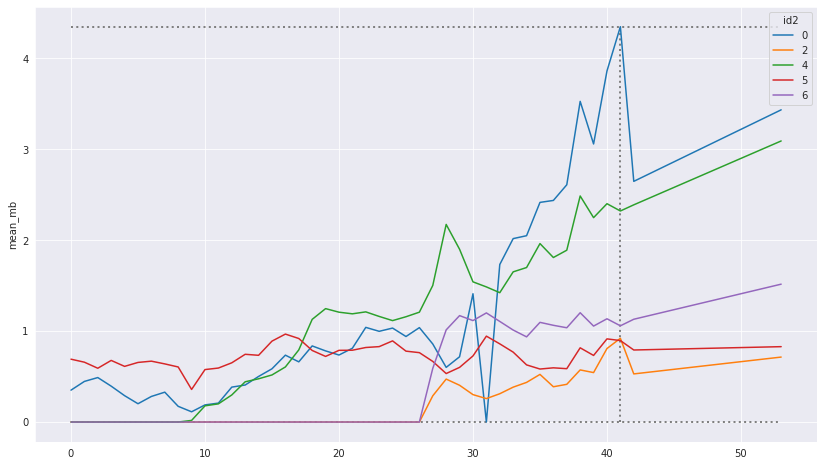

In [189]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 8))

test_range = d['mb']['X_test']['time_idx'].unique()
test_range.sort()
test_range_min = test_range[0]
X_test = pd.DataFrame(test_range, columns=['time_idx'])

ymin = np.inf
ymax = -np.inf

for i, row in df_group.iterrows():

    row = row.map(lambda x: x if x>-10 else np.nan)
    ymax = np.max(row[:test_range_min]) if np.max(row[:test_range_min]) > ymax else ymax
    ymin = np.min(row[:test_range_min]) if np.min(row[:test_range_min]) < ymin else ymin
    row = row[~np.isnan(row)]
    
    model = LinearRegression().fit(transform_poly(np.array(row.index).reshape(-1, 1), 1), row.values)
    y_pred = model.predict(transform_poly(np.array(X_test).reshape(-1, 1), 1))
    row = row.append(pd.Series(y_pred), ignore_index=True)

    row.name = 'mean_mb'
    sns.lineplot(data=row)

plt.vlines(test_range_min-1, ymin, ymax, color='gray', linewidth=2, linestyle=':')
plt.hlines(ymin, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.hlines(ymax, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.legend(title='id2', labels=df_group.index.map(lambda x: x[1]))
plt.show()

### Строим предикт одной вышки по бустингу

In [190]:
# на основе mb
y_pred = pd.Series(d['mb']['LGBMRegressor']['y_pred'])
y_pred.name = 'mb'
y_pred.index = d['mb']['X_test'].index

df_group1 = pd.concat([d['mb']['X_train'], d['mb']['y_train']], axis=1)
df_group2 = pd.concat([d['mb']['X_test'], y_pred], axis=1)

df_group = pd.concat([df_group1, df_group2])
df_group = df_group[ df_group['place_id'] == number ].groupby(['place_id', 'id2', 'time_idx'])['mb'].mean().unstack(fill_value=0.0)
df_group

time_idx       0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18  \
place_id id2                                                                                                  
608      0   0.35 0.45 0.49 0.39 0.29 0.20 0.28 0.33 0.17 0.11 0.19 0.21 0.38 0.41 0.50 0.59 0.74 0.66 0.84   
         2   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
         4   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.18 0.20 0.30 0.44 0.48 0.52 0.61 0.79 1.13   
         5   0.69 0.66 0.59 0.68 0.61 0.66 0.67 0.64 0.61 0.36 0.58 0.59 0.65 0.75 0.73 0.89 0.97 0.92 0.79   
         6   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

time_idx       19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37  \
place_id id2                                                                                                  
608      0   0.78 0.74 0.81 1.04 1.00 1.03 0.94 1.04 0.86 0.60 0.72 1.41 0.00 1.73 2.02 2.05 2.42 2.44 2.61   
         2   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.29 0.47 0.40 0.30 0.26 0.31 0.38 0.44 0.52 0.39 0.41   
         4   1.25 1.21 1.19 1.21 1.16 1.12 1.16 1.21 1.50 2.17 1.90 1.54 1.49 1.42 1.65 1.70 1.96 1.81 1.89   
         5   0.72 0.79 0.79 0.82 0.83 0.89 0.78 0.76 0.67 0.53 0.60 0.73 0.95 0.86 0.77 0.63 0.58 0.60 0.59   
         6   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.59 1.01 1.17 1.12 1.20 1.11 1.01 0.94 1.10 1.06 1.04   

time_idx       38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53  
place_id id2                                                                                  
608      0   3.53 3.06 3.86 4.35 3.86 3.87 3.87 3.86 3.70 3.70 3.74 3.74 3.75 3.71 3.71 3.45  
         2   0.57 0.54 0.81 0.92 0.65 0.66 0.66 0.79 0.79 0.79 0.82 0.82 0.83 0.79 0.80 0.78  
         4   2.49 2.25 2.40 2.32 2.35 2.36 2.36 2.34 2.29 2.29 2.33 2.33 2.34 2.31 2.34 2.29  
         5   0.82 0.73 0.91 0.90 1.24 1.25 1.25 1.21 1.16 1.16 1.15 1.16 1.19 1.20 1.19 1.14  
         6   1.20 1.06 1.14 1.06 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.94 0.94 0.94 0.92

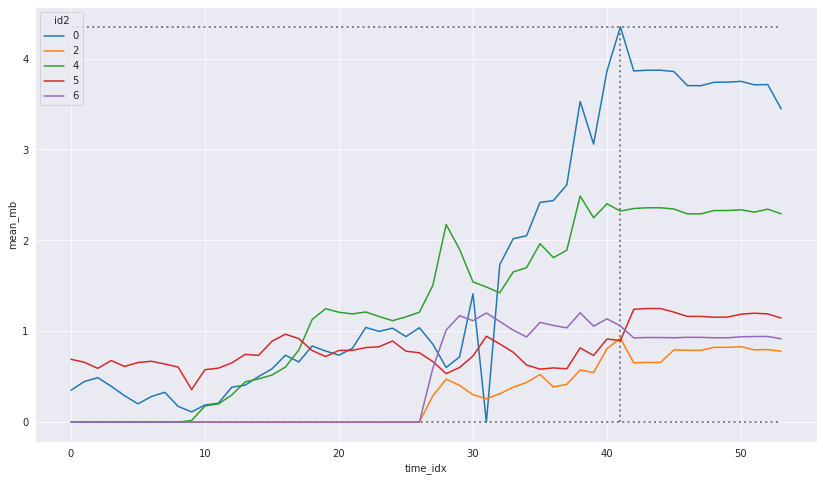

In [191]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 8))

test_range = d['mb']['X_test']['time_idx'].unique()
test_range.sort()
test_range_min = test_range[0]
X_test = pd.DataFrame(test_range, columns=['time_idx'])

ymin = np.inf
ymax = -np.inf

for i, row in df_group.iterrows():

    row = row.map(lambda x: x if x>-10 else np.nan)
    ymax = np.max(row[:test_range_min]) if np.max(row[:test_range_min]) > ymax else ymax
    ymin = np.min(row[:test_range_min]) if np.min(row[:test_range_min]) < ymin else ymin
    row = row[~np.isnan(row)]

    row.name = 'mean_mb'
    sns.lineplot(data=row)

plt.vlines(test_range_min-1, ymin, ymax, color='gray', linewidth=2, linestyle=':')
plt.hlines(ymin, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.hlines(ymax, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.legend(title='id2', labels=df_group.index.map(lambda x: x[1]))
plt.show()

In [192]:
# на основе log_mb
y_pred = pd.Series(np.exp(d['log_mb']['LGBMRegressor']['y_pred']) - 1e-15)
y_pred.name = 'log_mb'
y_pred.index = d['log_mb']['X_test'].index

y_train = np.exp(d['log_mb']['y_train']) - 1e-15

df_group1 = pd.concat([d['log_mb']['X_train'], y_train], axis=1)
df_group2 = pd.concat([d['log_mb']['X_test'], y_pred], axis=1)

df_group = pd.concat([df_group1, df_group2])
df_group = df_group[ df_group['place_id'] == number ].groupby(['place_id', 'id2', 'time_idx'])['log_mb'].mean().unstack(fill_value=0.0)
df_group

time_idx       0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18  \
place_id id2                                                                                                  
608      0   0.35 0.45 0.49 0.39 0.29 0.20 0.28 0.33 0.17 0.11 0.19 0.21 0.38 0.41 0.50 0.59 0.74 0.66 0.84   
         2   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
         4   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.18 0.20 0.30 0.44 0.48 0.52 0.61 0.79 1.13   
         5   0.69 0.66 0.59 0.68 0.61 0.66 0.67 0.64 0.61 0.36 0.58 0.59 0.65 0.75 0.73 0.89 0.97 0.92 0.79   
         6   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

time_idx       19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37  \
place_id id2                                                                                                  
608      0   0.78 0.74 0.81 1.04 1.00 1.03 0.94 1.04 0.86 0.60 0.72 1.41 0.00 1.73 2.02 2.05 2.42 2.44 2.61   
         2   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.29 0.47 0.40 0.30 0.26 0.31 0.38 0.44 0.52 0.39 0.41   
         4   1.25 1.21 1.19 1.21 1.16 1.12 1.16 1.21 1.50 2.17 1.90 1.54 1.49 1.42 1.65 1.70 1.96 1.81 1.89   
         5   0.72 0.79 0.79 0.82 0.83 0.89 0.78 0.76 0.67 0.53 0.60 0.73 0.95 0.86 0.77 0.63 0.58 0.60 0.59   
         6   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.59 1.01 1.17 1.12 1.20 1.11 1.01 0.94 1.10 1.06 1.04   

time_idx       38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53  
place_id id2                                                                                  
608      0   3.53 3.06 3.86 4.35 3.49 3.50 3.50 3.40 3.13 3.09 3.11 3.14 3.42 3.40 3.42 3.41  
         2   0.57 0.54 0.81 0.92 0.54 0.54 0.54 0.73 0.73 0.73 0.71 0.72 0.76 0.75 0.74 0.74  
         4   2.49 2.25 2.40 2.32 1.95 1.98 1.98 1.95 1.98 1.99 2.00 2.02 2.07 2.05 1.99 1.98  
         5   0.82 0.73 0.91 0.90 1.07 1.09 1.09 1.05 0.98 0.97 0.95 0.96 1.03 1.03 1.02 1.02  
         6   1.20 1.06 1.14 1.06 0.74 0.75 0.75 0.74 0.73 0.72 0.72 0.73 0.75 0.74 0.72 0.72

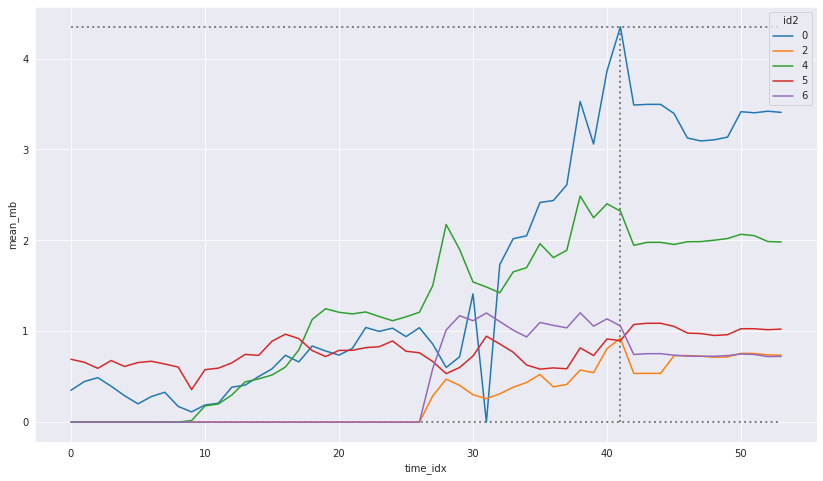

In [193]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 8))

test_range = d['mb']['X_test']['time_idx'].unique()
test_range.sort()
test_range_min = test_range[0]
X_test = pd.DataFrame(test_range, columns=['time_idx'])

ymin = np.inf
ymax = -np.inf

for i, row in df_group.iterrows():

    row = row.map(lambda x: x if x>-10 else np.nan)
    ymax = np.max(row[:test_range_min]) if np.max(row[:test_range_min]) > ymax else ymax
    ymin = np.min(row[:test_range_min]) if np.min(row[:test_range_min]) < ymin else ymin
    row = row[~np.isnan(row)]

    row.name = 'mean_mb'
    sns.lineplot(data=row)

plt.vlines(test_range_min-1, ymin, ymax, color='gray', linewidth=2, linestyle=':')
plt.hlines(ymin, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.hlines(ymax, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.legend(title='id2', labels=df_group.index.map(lambda x: x[1]))
plt.show()

In [194]:
# на основе change_mb
y_pred = pd.Series(d['change_mb']['LGBMRegressor']['y_pred'])
y_pred.name = 'change_mb'
y_pred.index = d['change_mb']['X_test'].index

y_train = d['change_mb']['y_train']

df_group1 = pd.concat([d['change_mb']['X_train'], y_train], axis=1)
df_group2 = pd.concat([d['change_mb']['X_test'], y_pred], axis=1)

df_group = pd.concat([df_group1, df_group2])
df_group = df_group[ df_group['place_id'] == number ].groupby(['place_id', 'id2', 'time_idx'])['change_mb'].mean().unstack(fill_value=0.0)
df_group

time_idx        0     1     2     3     4     5    6     7     8     9    10   11   12   13    14   15   16  \
place_id id2                                                                                                  
608      0   -0.01  0.10  0.04 -0.09 -0.10 -0.09 0.08  0.05 -0.16 -0.06 0.08 0.02 0.18 0.02  0.09 0.08 0.15   
         2   -0.01  0.00  0.00  0.00  0.00  0.00 0.00  0.00  0.00  0.00 0.00 0.00 0.00 0.00  0.00 0.00 0.00   
         4    0.01  0.00  0.00  0.00  0.00  0.00 0.00  0.00  0.00  0.02 0.16 0.02 0.10 0.14  0.03 0.04 0.09   
         5   -0.00 -0.03 -0.07  0.09 -0.07  0.04 0.01 -0.03 -0.03 -0.25 0.22 0.02 0.06 0.09 -0.01 0.16 0.08   
         6   -0.00  0.00  0.00  0.00  0.00  0.00 0.00  0.00  0.00  0.00 0.00 0.00 0.00 0.00  0.00 0.00 0.00   

time_idx        17    18    19    20    21   22    23    24    25    26    27    28    29    30    31    32  \
place_id id2                                                                                                  
608      0   -0.07  0.18 -0.05 -0.05  0.07 0.23 -0.04  0.04 -0.09  0.10 -0.18 -0.26  0.12  0.69  0.29  0.03   
         2    0.00  0.00  0.00  0.00  0.00 0.00  0.00  0.00  0.00  0.00  0.29  0.18 -0.07 -0.10 -0.04  0.05   
         4    0.19  0.34  0.12 -0.04 -0.02 0.02 -0.05 -0.05  0.04  0.05  0.29  0.67 -0.27 -0.36 -0.06 -0.06   
         5   -0.05 -0.13 -0.07  0.07  0.00 0.03  0.01  0.06 -0.11 -0.02 -0.10 -0.13  0.07  0.13  0.22 -0.09   
         6    0.00  0.00  0.00  0.00  0.00 0.00  0.00  0.00  0.00  0.00  0.59  0.42  0.16 -0.05  0.08 -0.09   

time_idx        33    34    35    36    37   38    39   40    41   42   43   44   45   46   47    48   49  \
place_id id2                                                                                                
608      0    0.28  0.03  0.37  0.02  0.17 0.92 -0.47 0.80  0.49 0.23 0.23 0.22 0.21 0.11 0.23  0.12 0.20   
         2    0.07  0.05  0.09 -0.14  0.03 0.16 -0.03 0.26  0.11 0.04 0.03 0.03 0.07 0.06 0.08  0.04 0.09   
         4    0.23  0.05  0.26 -0.15  0.08 0.60 -0.24 0.15 -0.08 0.03 0.03 0.03 0.03 0.02 0.07 -0.00 0.11   
         5   -0.09 -0.14 -0.05  0.01 -0.01 0.23 -0.08 0.18 -0.02 0.04 0.05 0.05 0.04 0.03 0.05  0.00 0.06   
         6   -0.09 -0.08  0.16 -0.03 -0.03 0.17 -0.15 0.08 -0.08 0.01 0.02 0.02 0.02 0.01 0.04 -0.01 0.03   

time_idx       50    51   52    53  
place_id id2                        
608      0   0.17  0.13 0.14  0.05  
         2   0.07  0.04 0.05  0.04  
         4   0.07 -0.04 0.01  0.00  
         5   0.08  0.02 0.04  0.02  
         6   0.04 -0.01 0.00 -0.01

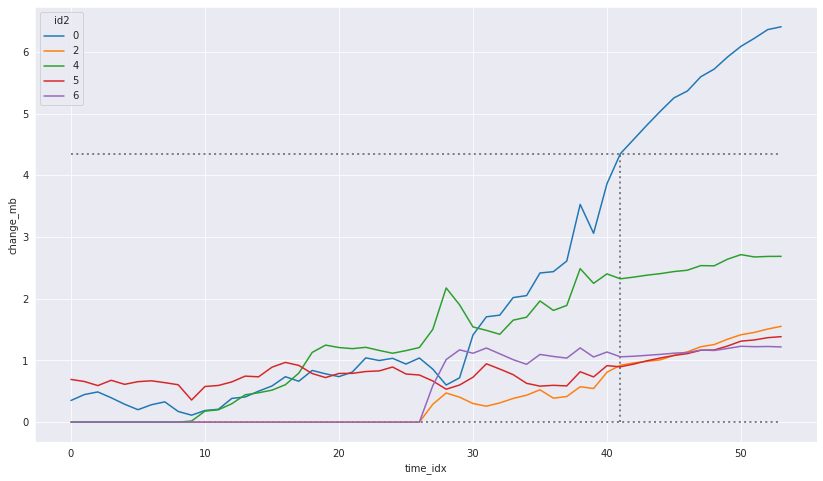

In [195]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 8))

test_range = d['change_mb']['X_test'][ d['change_mb']['X_test']['time_idx'] != 0]['time_idx'].unique()
test_range.sort()
test_range_min = test_range[0]
X_test = pd.DataFrame(test_range, columns=['time_idx'])
mb_id = dict(df[ (df['place_id'] == number) & (df['time_idx'] == 0) ][['id2', 'mb']].values)

ymin = np.inf
ymax = -np.inf

for i, row in df_group.iterrows():

    row[0] = mb_id[i[1]]
    for k in range(1, len(row)):
        row[k] += row[k-1]
    row = row.map(lambda x: x if x>-10 else np.nan)
    ymax = np.max(row[:test_range_min]) if np.max(row[:test_range_min]) > ymax else ymax
    ymin = np.min(row[:test_range_min]) if np.min(row[:test_range_min]) < ymin else ymin
    row = row[~np.isnan(row)]

    row.name = 'change_mb'
    sns.lineplot(data=row)

plt.vlines(test_range_min-1, ymin, ymax, color='gray', linewidth=2, linestyle=':')
plt.hlines(ymin, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.hlines(ymax, xmin=0, xmax=test_range[-1], color='gray', linewidth=2, linestyle=':')
plt.legend(title='id2', labels=df_group.index.map(lambda x: x[1]))
plt.show()